# Hierarchical Bayesian model for COVID-19 Data Set

Resources:
- Data: [Coronavirus (COVID-19) Case Counts](https://data.world/covid-19-data-resource-hub/covid-19-case-counts) maintained by Johns Hopkins and Tableau Inc.
- Modeling package: [PyMC3](https://docs.pymc.io/), a probabilstic programming library offering variational inference and MCMC.

A hierarchical model is a model that shares parameters between "levels" of variables. In this case, the growth rate is of total cases and total deaths is shared, with tolerance for some amount of deviation an average value. This allows the model to simultaneously fit the total cases, daily change in cases, total deaths, and daily change in deaths, allowing for tolerance of error in measurements of these values which is reconciled by the model explaining all observations simultaneously.

A latent random variable, the fatality rate, links these two data sets. Although we know of its existence, we do not know what value it takes - we refer to this as a latent variable as it must be inferred from observation of the variables it influences. The model structure is visualized as a probabilistic graphical model. While the model is actually more complex than this, the simplified structure shown below is useful for reasoning about the general model mechanics.  

![Probabilistic Graphical Model](img/pgm.png)  

One of the challenges with the COVID-19 data set is that inadequate testing means that the data itself is likely to have measurement error; that is, it deviates from the true (unknown) values of cases and deaths. Part of this we have to live with, but by fitting our model, and providing a link through the fatality rate, we can use our model to make some inference about what parts of the data are more or less likely to be in error.

Priors in this model are expressed for the fatality rate, which is formulated from interpretation of the data, and the total cases. A comparison of the priors and posteriors is provided below. Analysis of the fatality rate is utilized to inform the respective prior, while the prior for total cases is estimated from interpretation of the data, and is given a wide variance to minimize its influence.

_**Notice:**_ The model assumes the total confirmed case has measurement error greater than the total deaths, and therefore the model fit of total confirmed cases is an inference from the observed data as well as the fatality rate. Recently, the total confirmed cases has shown a decrease in growth rate, but the total deaths have not. This leads the model to infer that the total cases must be greater than is actually being reported. You will see this manifest as a forecast of more cases than the data shows.

**Fatality Rate vs. Date:**  
![Fatality Rate vs DAte](img/Fatality%20Rate_v_Date.png)  

**Fatality Rate Histogram used to inform prior:**  
![Fatality Rate Histogram](img/Fatality%20Rate%20Hist.png)  

**Confirmed Cases Forecast:**  
![Confirmed Cases Forecast](img/Confirmed%20Cases%20Forecast.png)  

**Deaths Forecast:**  
![Deaths Forecast](img/Deaths%20Forecast.png)

**$R_t$ vs. Date:**
![Rt vs Date](img/Rt_v_Date.png)

**Fatality Rate Posterior:**  
![Fatality Rate Posterior](img/Fatality%20Rate%20Posterior.png)

**Total Confirmed Cases Posterior:**
![Confirmed Cases Posterior](img/Total%20Cases%20Posterior.png)

**Total Deaths Posterior:**
![Total Deaths Posterior](img/Total%20Deaths%20Posterior.png)

# Program

### Imports & Setup

In [1]:
from pathlib import Path
import shutil
import warnings
import pickle
from datetime import datetime
from functools import partial
import numpy as np
import pandas as pd
import scipy
import daft
import pymc3 as pm
import theano
import theano.tensor as tt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from theano.tensor import as_tensor_variable as atv

from typing import List, Dict, Tuple, Union, Iterable, Optional
from numpy import ndarray
from theano.tensor.var import TensorConstant, TensorVariable
from pymc3.backends.base import MultiTrace
Tensor = Union[TensorConstant, TensorVariable]
Number = Union[
    int, float,
    np.int, np.int8, np.int16, np.int32, np.int64,
    np.float, np.float16, np.float32, np.float64,
]

path = Path()
img_path = path / 'img'

warnings.simplefilter('ignore')

mpl.rcParams['font.size'] = 14
plt.style.use('seaborn-white')
colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]

EXP_GAMMA = np.exp(.57721566)
NORM_80 = 2 * scipy.stats.norm.ppf(.9)

def log_sp(x: Union[ndarray, float, int]):
    return np.log(x + 1e-100)

def cp(fname: str, bname: str):
    shutil.copy(path / fname, img_path / bname)

In [2]:
class Norm(): 
    norm = scipy.stats.norm

    def fit(self, data: Iterable[Union[int, float, ndarray]]) -> Tuple[float, float]:
        self.data = data
        self.args = self.norm.fit(data)
        return self.args

    def pdf(self, q: Iterable[Union[int, float, ndarray]], *args: Tuple[float, float]):    
        if q is None:
            q = self.q
        else:
            self.q = q
            
        if args:
            self.args = args
        else:
            args = self.args               

        return self.norm.pdf(q, *args) 

class Lognorm(): 
    lognorm = scipy.stats.lognorm

    def fit(self, data: Iterable[Union[int, float, ndarray]]) -> Tuple[float, float, float]:
        self.data = data
        self.args = self.lognorm.fit(data, floc=0)
        return self.args

    def pdf(self, q: Iterable[Union[int, float, ndarray]], *args: Tuple[float, float, float]):
        if q is None:
            q = self.q
        else:
            self.q = q
            
        if args:
            self.args = args
        else:
            args = self.args                

        return self.lognorm.pdf(q, *args) 

norm = Norm()
lognorm = Lognorm()

In [3]:
def gompertz(a: Union[Number, ndarray], b: Union[Number, ndarray],
             s: Union[Number, ndarray], g: Union[Number, ndarray], t: Union[Number, ndarray]) -> ndarray:
    def f(a: Number, b: Number, s: Number, g: Number, t: Union[Number, ndarray]) -> ndarray:
        return a + (b - a) * np.exp(-np.exp(EXP_GAMMA * (1 - (t - s) / g)))

    params = np.c_[a, b, s, g]
    if params.shape[0] == 1:
        return f(*params[0], t)
    return np.apply_along_axis(lambda p: f(*p, t), axis=1, arr=params)
    

def tt_gompertz(a: Tensor, b: Tensor, s: Tensor, g: Tensor, t: Union[Number, ndarray, Tensor]) -> Tensor:
    return a + (b - a) * tt.exp(-tt.exp(EXP_GAMMA * (1 - (t - s) / g)))

In [4]:
def change(x: ndarray, y: ndarray) -> ndarray:
    # data given as daily count, so use first order difference to match
    return (y[1:] - y[:-1]) / (x[1:] - x[:-1])

def log_change(x: ndarray, y: ndarray) -> ndarray:
    return change(x, np.log(y))

def perc_change(x: ndarray, y: ndarray) -> ndarray:
    return np.exp(log_change(x, y)) - 1

def mvg_avg(y: ndarray, p: int = 6) -> ndarray:
    return np.mean([y[i:-(p - i)] for i in range(p)], axis=0)

### Data Load

In [5]:
df = pd.read_csv('https://query.data.world/s/uoa7gmlbnng5535pciks3mqfqugja5')
df = df.loc[df['Country_Region'] == 'US', ['Case_Type', 'Cases', 'Date']]
df['Date'] = pd.to_datetime(df['Date'])

df = df.pivot_table(values='Cases', index='Date', columns='Case_Type', aggfunc=np.sum)
df.reset_index(inplace=True)
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

time = df['Days'].values
date = df['Date'].values
cases = df['Confirmed'].values
deaths = df['Deaths'].values

### Analysis

In [6]:
label_date = datetime.now().strftime(f'%B %d')
# label_date = 'April 14'
print(label_date)

April 30


In [31]:
def rate(savefig: bool = False):
    c0 = mpl.colors.to_rgb('b')
    c1 = mpl.colors.to_rgb('r')
    mc = dict(mec=(*c0, 1), mfc=(*c0, .25), zorder=2, label='Data')
    fmc = dict(mec=(*c1, 1), mfc='white', zorder=2, label='Not Used for Prior')
        
    t_min = np.nonzero(deaths)[0][0]
    offset = 3
    fltr = np.searchsorted(deaths, 50) - np.nonzero(deaths)[0][0]
    rate = np.cumsum(deaths) / np.cumsum(cases)
    mean_fltr = np.mean(rate[t_min + fltr:])
    mean_time = np.mean(rate[t_min:])
    mean_total = np.sum(deaths) / np.sum(cases)

    ### time series
    fig, ax = plt.subplots(figsize=(8.7, 8))

    ax.plot(date[t_min - offset:], rate[t_min - offset:], 'o', **mc)
    ax.plot(date[t_min - offset:t_min + fltr], rate[t_min - offset:t_min + fltr], 'o', **fmc)
    ax.axhline(mean_fltr, c='C0', ls='--', zorder=0, label='Average over Used Time')
    ax.axhline(mean_time, c='C1', ls='--', zorder=0, label='Average over Time')
    ax.axhline(mean_total, c='C2', ls='--', zorder=0, label='Average over Total')
    ax.axvline(date[t_min + fltr], c='k', ls=':', zorder=0, label='Date of 50 total deaths')  

    ax.set(ylim=(None, .0725))
    ax.set(ylabel='Fatality Rate', xlabel='Date', title=f'Fatality Rate vs. Date - Data: {label_date}')
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax.tick_params(axis='x', rotation=25)

    ax.grid()
    ax.legend(loc='lower right')

    ax.annotate(f'{mean_fltr:.2%}', xy=(date[-14], mean_fltr), xytext=(date[-18], mean_fltr-.0025), c='C0')
    ax.annotate(f'{mean_time:.2%}', xy=(date[-14], mean_time), xytext=(date[-15], mean_time+.0015), c='C1')
    ax.annotate(f'{mean_total:.2%}', xy=(date[-14], mean_total), xytext=(date[-15], mean_total+.0015), c='C2')

    if savefig:
        bname = 'Fatality Rate_v_Date.png'
        fname = f'{label_date}_{bname}'
        plt.savefig(fname, dpi=75, bbox_inches='tight')
        cp(fname, bname)
    else:
        plt.show()
        
    ### histogram
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.distplot(rate[t_min + fltr:], bins=10, fit=lognorm, ax=ax)
    ax.plot([], [], c='C0', label='Kernel Density Estimate')
    ax.plot([], [], c='k', label='Lognormal Fit')
    
    mu = np.log(lognorm.args[2])
    sigma = lognorm.args[0]
    p10p90 = np.exp(sigma * NORM_80)
    mean = np.exp(mu + sigma ** 2 / 2)
    std = np.sqrt(mean ** 2 * (np.exp(sigma ** 2) - 1))
    
    ax.plot([mean, mean], [0, lognorm.pdf(mean)], c='k', ls='--', label='Mean')
    std_p1 = np.exp(mu + sigma ** 2 / 2 + sigma)
    std_m1 = np.exp(mu + sigma ** 2 / 2 - sigma)
    ax.plot([std_p1, std_p1], [0, lognorm.pdf(std_p1)], c='k', ls=':', Label='$\pm$ 1 Std. Dev.')
    ax.plot([std_m1, std_m1], [0, lognorm.pdf(std_m1)], c='k', ls=':')
    
    ypos = .75
    ax.text(.68, ypos, f'Mean: {mean:.2%}', transform=ax.transAxes)
    ax.text(.68, ypos - .05, f'Std. Dev.: {std:.2%}', transform=ax.transAxes)
    ax.text(.68, ypos - .1, f'P10/P90: {p10p90:.2f}', transform=ax.transAxes)

    ax.set(title=f'Fatality Rate Histogram - Data: {label_date}', xlabel='Fatality Rate', ylabel='Density')
    ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax.grid()
    ax.legend(loc='upper right')
    plt.tight_layout()

    if savefig:
        bname = 'Fatality Rate Hist.png'
        fname = f'{label_date}_{bname}'
        plt.savefig(fname, dpi=75, bbox_inches='tight')
        cp(fname, bname)
    else:
        plt.show()

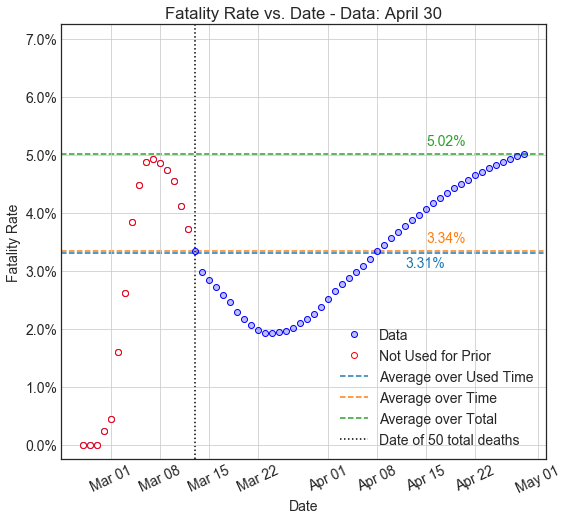

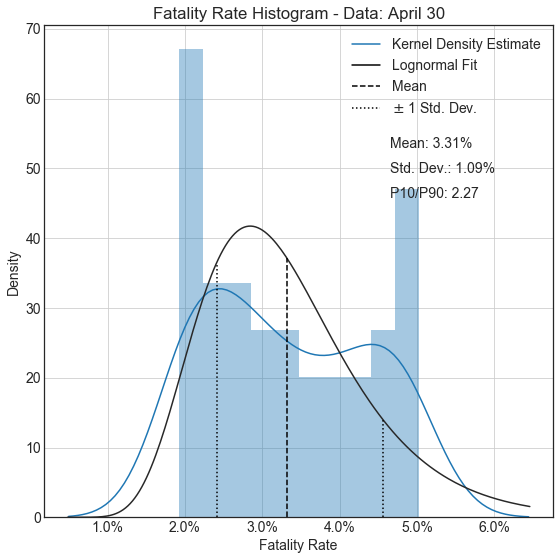

In [32]:
rate(savefig=True)

### Hierarchical Modeling

If we have a stage I parameter $\theta$, and stage II parameters $\theta_a$ and $\theta_b$, then:  

$$
\theta_a = P(\theta, \sigma_a) \\
\theta_b = P(\theta, \sigma_b)
$$  

For two stage II parameters, we have the following simplification:  

$$
\theta_a = P(\theta, \sigma_a) = \theta + P(0, \sigma_a) \\
\theta = \theta_a - P(0, \sigma_a) \\
\theta_b = P(\theta_a - P(0, \sigma_a), \sigma_b) \\
\theta_b = P(\theta_a, \sigma_a +  \sigma_b) \\   
\theta_b = P(\theta_a, \sigma_c)
$$

### Setup

In [9]:
def run_both(
    cases_a: Optional[float] = None, cases_b: Optional[float] = None,
    cases_b_p10p90: float = 3.0,
    deaths_a: Optional[float] = None,
    rate_mu: Optional[float] = None, rate_sigma: Optional[float] = None,
    sigma: float = 1.0, totals_wt: float = 1.0, cases_wt: float = 1.0,
    forecast_len: int = 193, cases_tmin: int = 0, deaths_tmin: int = 0,
    tune=500, draws=500) -> MultiTrace:
    """
    Parameters
        cases_a: minimum of confirmed cases
        cases_b: mean of maximum of confirmed cases
        cases_b_p10p90: P10/P90 ratio of confirmed cases
        deaths_a: minimum of deaths
        rate: determnistic death rate (otherwise based upon statistics of data)
        sigma: deterministic variance (recommended as method of fixing measurement error of data)
        totals_wt: additional variance for totals curves
        cases_wt: additional variance for cases (relative to deaths)
        forecast_len: number of days to forecast
        cases_tmin: lower element of slice on cases
        deaths_tmin: lower element of slice on deaths
        tune: number of burn-in trials
        draws: number of samples
    """
    
    with pm.Model() as model:        
        ### death rate
        if rate_mu is None:
            rate = pm.Uniform('rate', lower=1e-3, upper=0.20)
        elif rate_sigma is None:
            rate = pm.Deterministic('rate', atv(rate_mu))
        else:
            sd = np.sqrt(np.log((rate_sigma / rate_mu) ** 2 + 1))
            mu = np.log(rate_mu) - sd ** 2 / 2
            rate = pm.Lognormal('rate', mu=mu, sd=sd, testval=.022)            
#             rate = pm.Bound(pm.Normal, lower=0.0)('rate', mu=rate_mu, sd=rate_sigma, testval=.022)


        ### minimum
        # cases
        if cases_a is not None:
            cases_a = pm.Deterministic('cases_a', atv(cases_a))
        else:
            cases_a = pm.Uniform('cases_a', lower=0, upper=100, testval=50)
            
        # deaths
        if deaths_a is not None:
            deaths_a = pm.Deterministic('deaths_a', atv(deaths_a))
        else:
            deaths_a = pm.Uniform('deaths_a', lower=0, upper=100, testval=50)
            

        ### capacity
        #cases
        if cases_b is not None:
            sd = np.log(cases_b_p10p90) / NORM_80
            mu = np.log(cases_b) - sd ** 2 / 2            
            cases_b = pm.Lognormal('cases_b', mu=mu, sd=sd)
        else:
            cases_b = pm.HalfFlat('cases_b', testval=1e7)
            
        # deaths
        deaths_b = pm.Deterministic('deaths_b', rate * cases_b)   
        

        ### shift
        deaths_s = pm.Uniform('deaths_s', lower=0, upper = 100, testval=50)
        _cases_s = pm.Normal('_cases_s', mu=0.0, sd=14.0, testval=0)
        cases_s = pm.Deterministic('cases_s', deaths_s + _cases_s)

        
        ### growth rate
        deaths_g = pm.Uniform('deaths_g', lower=0, upper = 100, testval=50)
        _cases_g = pm.Normal('_cases_g', mu=0.0, sd=14.0, testval=0)
        cases_g = pm.Deterministic('cases_g', deaths_g + _cases_g)

        
        ### error
#         sigma = pm.HalfNormal('sigma', 1.0, testval=1)
        sigma = pm.Deterministic('sigma', atv(sigma))
        
        
        ### likelihood
        # cases
        pm.Deterministic('cases', atv(cases))
        cases_scale = cases[-1]
        cases_x = pm.Data('cases_x', time[cases_tmin:])
        cases_y = pm.Data('cases_y', cases[cases_tmin:]) / cases_scale
        cases_f = tt_gompertz(cases_a, cases_b, cases_s, cases_g, cases_x) / cases_scale
        cases_df = cases_f[1:] - cases_f[:-1]
        cases_dc = cases_y[1:] - cases_y[:-1]
        
        pm.Normal('cases_f', log_sp(cases_f), sigma +  totals_wt + cases_wt, observed=log_sp(cases_y))
        pm.Normal('cases_df', log_sp(cases_df), sigma + cases_wt, observed=log_sp(cases_dc))

        # deaths
        pm.Deterministic('deaths', atv(deaths))
        deaths_scale = deaths[-1]
        deaths_x = pm.Data('deaths_x', time[deaths_tmin:])
        deaths_y = pm.Data('deaths_y', deaths[deaths_tmin:]) / deaths_scale
        deaths_f = tt_gompertz(deaths_a, deaths_b, deaths_s, deaths_g, deaths_x) / deaths_scale
        deaths_df = deaths_f[1:] - deaths_f[:-1]
        deaths_dc = deaths_y[1:] - deaths_y[:-1]
        
        pm.Normal('deaths_f', log_sp(deaths_f), sigma + totals_wt, observed=log_sp(deaths_y))
        pm.Normal('deaths_df', log_sp(deaths_df), sigma, observed=log_sp(deaths_dc))

        # model probability
        pm.Deterministic('logp', model.logpt)

        trace = pm.sample(tune=tune, draws=draws, chains=1, cores=1, target_accept=.9)
        
#         x_data = np.arange(0, forecast_len)
#         y_data = np.array([np.nan] * len(x_data))
#         pm.set_data({
#             'cases_x': x_data,
#             'cases_y': y_data,
#             'deaths_x': x_data,
#             'deaths_y': y_data
#         })
        
#         post_pred = pm.sample_posterior_predictive(trace, samples=draws)
        
    return trace

### Run

In [10]:
cases_b = 5e6
cases_b_p10p90 = 4
rate_mu = 0.03
rate_sigma = .01

In [11]:
model_date = 'April 6'

In [186]:
trace = run_both(
    cases_a=15.0, cases_b=cases_b, cases_b_p10p90=cases_b_p10p90,
    deaths_a=1.0, rate_mu=rate_mu, rate_sigma=rate_sigma,
    sigma=0.5, totals_wt=0.25, cases_wt=1.0,
    cases_tmin = np.searchsorted(cases, 1000),
    deaths_tmin = np.searchsorted(deaths, 100),
    tune=1000, draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [_cases_g, deaths_g, _cases_s, deaths_s, cases_b, rate]
Sampling chain 0, 0 divergences: 100%|███████████████████████| 2000/2000 [00:09<00:00, 220.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [127]:
with open(f'model_{model_date}.pkl', 'wb') as f:
    pickle.dump(trace, f)

In [12]:
with open(f'model_{model_date}.pkl', 'rb') as f:
    trace = pickle.load(f)

### Figures

In [13]:
def dashboard_b(
    forecast_len: int = 193, savefig: bool = False,
    lim_cases: Dict = {}, lim_deaths: Dict = {}) -> plt.Figure:
    """
    Parameter Description:
        a - minimum of growth function
        b - maximum of growth function (carrying capacity)
        s - shift parameter (e.g. start date/time)
        g - growth rate
        
    Time and Date are both given
    """
    
    logp = trace['logp']
    sigma = trace['sigma']    
    
    sigma = np.mean(sigma)
    
    for case in ('cases', 'deaths'):        
        a = trace[f'{case}_a']
        b = trace[f'{case}_b']
        s = trace[f'{case}_s']
        g = trace[f'{case}_g']
        
        if case == 'cases':
            count = cases
            label = 'Confirmed Cases'
            lim1 = lim_cases.get('lim1', None)
            lim2 = lim_cases.get('lim2', 0.7)
            lim3 = lim_cases.get('lim3', 5e5)
            lim4 = lim_cases.get('lim4', None)            
        elif case == 'deaths':
            count = deaths
            label = 'Deaths'
            lim1 = lim_deaths.get('lim1', None)
            lim2 = lim_deaths.get('lim2', 0.7)
            lim3 = lim_deaths.get('lim3', 5e3)
            lim4 = lim_deaths.get('lim4', None)    
            

    
        fig, ax = plt.subplots(2, 2, figsize=(16, 16))            

        #data markers
        c0 = mpl.colors.to_rgb('b')
        mc = dict(mec=(*c0, 1), mfc=(*c0, .25), zorder=2, label='Data')
        md = dict(c='grey', alpha=.1, zorder=1)
        mmle = dict(c='r', zorder=3, label='Maximum Likelihood')

        # Posterior
        t_pred = np.arange(0, forecast_len)
        date_pred = np.min(date) + [np.timedelta64(t, 'D') for t in np.arange(0, forecast_len)]
    #     f = np.exp(
    #         np.log(gompertz(a, b, s, g, t_pred).T) 
    #         + np.random.normal(size=len(a)) * sigma
    #     )
        f = gompertz(a, b, s, g, t_pred).T

        # Maximum Likelihood Estimate
        mle = np.argmax(logp)
        f_mle = gompertz(a[mle], b[mle], s[mle], g[mle], t_pred).T
        mle_total = gompertz(a[mle], b[mle], s[mle], g[mle], forecast_len)

        ### Total Cases vs. Time
        ax[0, 0].plot(date, count, 'o', **mc)
        ax[0, 0].plot(date_pred, f, **md)
        ax[0, 0].plot([], [], c='grey', label='Posterior')
        ax[0, 0].plot(date_pred, f_mle, **mmle)

        ax[0, 0].grid()
        ax[0, 0].set(yscale='log', ylim=(1, lim1))
        ax[0, 0].set(ylabel=f'Total {label}', xlabel='Date')
        ax[0, 0].xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
        ax[0, 0].yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=20))
        ax[0, 0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:3,.0f}'))
        ax[0, 0].tick_params(axis='x', rotation=25)
        ax[0, 0].legend(loc='lower right')
        ax[0, 0].annotate(f'{mle_total:3,.0f} by Aug 1', xy=(date_pred[-1], mle_total),
                          xytext=(date_pred[-70], mle_total*.04),
                          arrowprops=dict(arrowstyle='->'))
        ax[0, 0].annotate(f'{b[mle]:3,.0f} Total', xy=(date_pred[-1], mle_total),
                          xytext=(date_pred[-70], mle_total*.015))


        ### Percent Growth vs. Time
        ax[0, 1].plot(date[1:], perc_change(time, count), 'o', **mc)
        ax[0, 1].plot(date_pred[1:], perc_change(t_pred[:, None], f), **md)
        ax[0, 1].plot(date_pred[1:], perc_change(t_pred, f_mle), **mmle)
    #     ax[0, 1].plot(date[4:-3], mvg_avg(perc_change(time, count), 6))

        ax[0, 1].grid()
        ax[0, 1].set(ylim=(0, lim2))
        ax[0, 1].set(ylabel=f'Percent Growth of {label}', xlabel='Date')
        ax[0, 1].xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
        ax[0, 1].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        ax[0, 1].tick_params(axis='x', rotation=25)


        ### Daily Change vs. Time
        ax[1, 0].plot(date[1:], change(time, count), 'o', **mc)
        ax[1, 0].plot(date_pred[1:], change(t_pred[:, None], f), **md)
        ax[1, 0].plot(date_pred[1:], change(t_pred, f_mle), **mmle)

        ax[1, 0].grid()
        ax[1, 0].set(ylim=(0, lim3))
        ax[1, 0].set(ylabel=f'Daily Change in {label}', xlabel='Date')
        ax[1, 0].xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
        ax[1, 0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:3,.0f}'))
        ax[1, 0].tick_params(axis='x', rotation=25)


        ### Daily Change vs. Cumulative Total Cases
        ax[1, 1].plot(count[1:], change(time, count), 'o', **mc)
        ax[1, 1].plot(f[1:, :], change(t_pred[:, None], f), **md)
        ax[1, 1].plot(f_mle[1:], change(t_pred, f_mle), **mmle)

        ax[1, 1].grid()
        ax[1, 1].set(yscale='log', xscale='log', xlim=(1, None), ylim=(1, lim4))
        ax[1, 1].set(ylabel=f'Daily Change in {label}', xlabel=f'Total {label}')
        ax[1, 1].xaxis.set_major_locator(mpl.ticker.LogLocator(numticks=20))
        ax[1, 1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:3,.0f}'))
        ax[1, 1].yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=20))
        ax[1, 1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:3,.0f}'))
        ax[1, 1].tick_params(axis='x', rotation=25)

        plt.suptitle(f'{label} - Model: {model_date} - Data: {label_date}', fontsize=24, y=.92)
        plt.subplots_adjust(wspace=0.25)

        if savefig:
            bname = f'{label} Forecast.png'
            fname = f'{label_date}_{bname}'
            plt.savefig(fname, dpi=75, bbox_inches='tight')
            cp(fname, bname)
        else:
            plt.show()

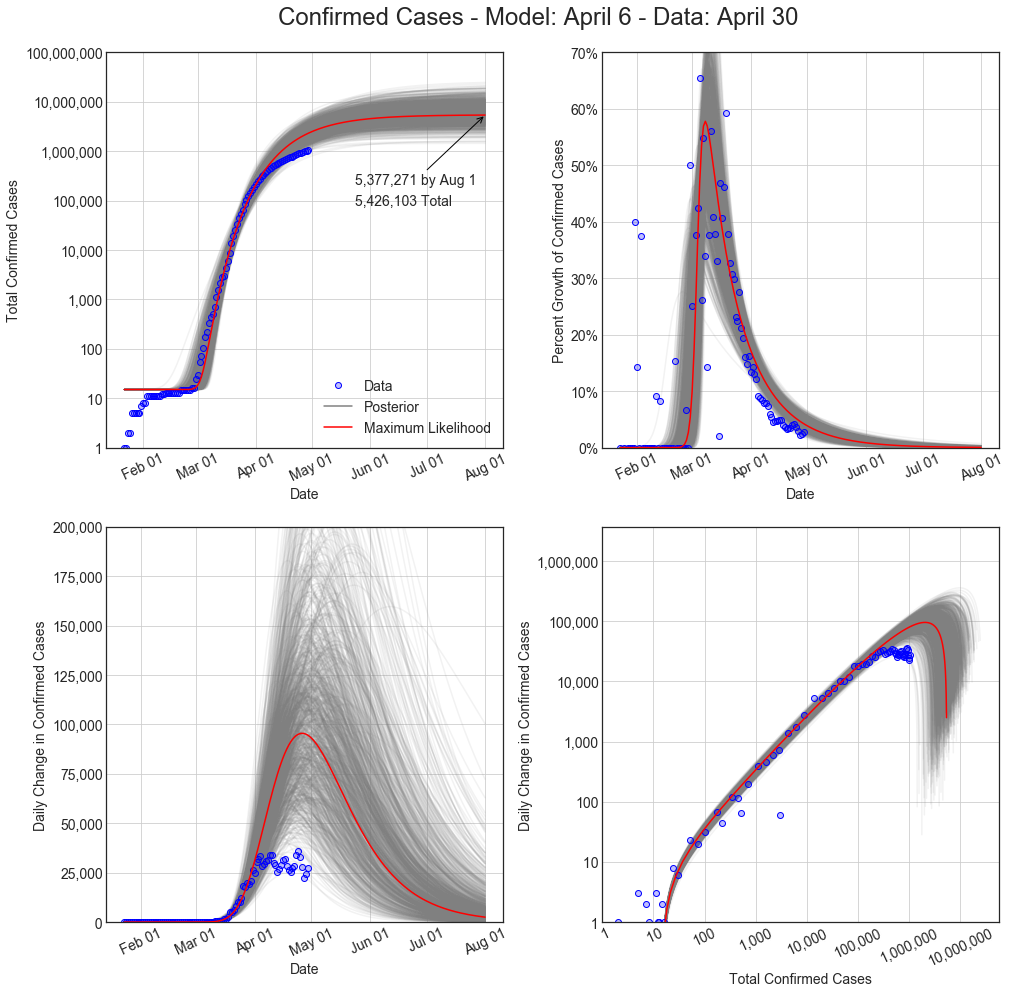

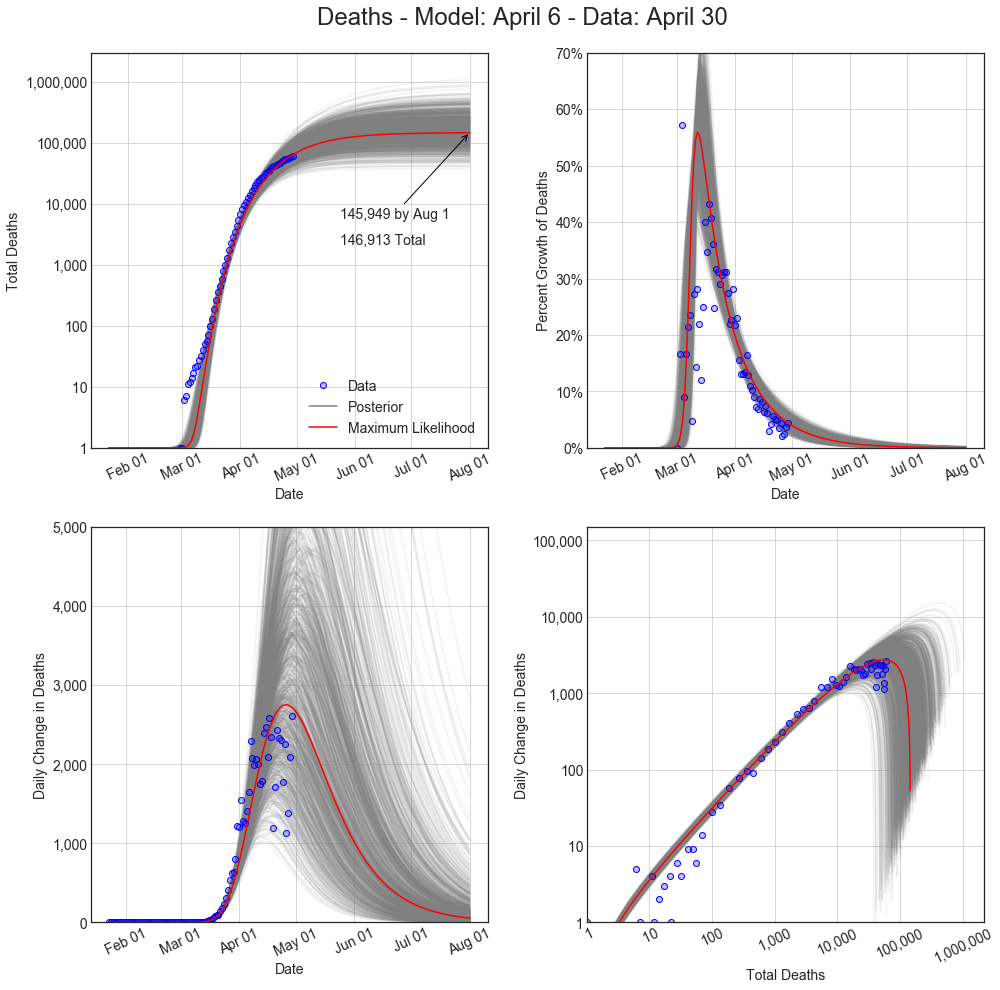

In [14]:
dashboard_b(savefig=True,
            lim_cases={'lim1': 100e6, 'lim3': 200e3},
            lim_deaths={'lim1': 3e6, 'lim3': 5e3})

In [15]:
def plot_rt(
    forecast_len: int = 193, p: int = 7, savefig: bool = False,
    gamma = 1.0 / 4.0,
    lim_cases: Dict = {}, lim_deaths: Dict = {}) -> plt.Figure:

    logp = trace['logp']
    sigma = trace['sigma']    

    sigma = np.mean(sigma)
    

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))   
    
    for case in (['cases', 'deaths']):        
        a = trace[f'{case}_a']
        b = trace[f'{case}_b']
        s = trace[f'{case}_s']
        g = trace[f'{case}_g']

        if case == 'cases':
            p_s = slice(p//2, -int(np.ceil(p/2)))
            t_mvg = time[p_s]
            count = cases
            c_mvg = mvg_avg(count, p)
            label = 'Confirmed Cases'
            lim1 = lim_cases.get('lim1', None)
            lim2 = lim_cases.get('lim2', 0.7)
            lim3 = lim_cases.get('lim3', 5e5)
            lim4 = lim_cases.get('lim4', None)  
            ax = axes[0]
            
        elif case == 'deaths':
            p_s = slice(p//2, -int(np.ceil(p/2)))
            t_mvg = time[p_s]
            count = deaths
            c_mvg = mvg_avg(count, p)
            label = 'Deaths'
            lim1 = lim_deaths.get('lim1', None)
            lim2 = lim_deaths.get('lim2', 0.7)
            lim3 = lim_deaths.get('lim3', 5e3)
            lim4 = lim_deaths.get('lim4', None) 
            ax = axes[1]


        #data markers
        c0 = mpl.colors.to_rgb('b')
        mc = dict(marker='o', ls='none', mec=(*c0, 1), mfc=(*c0, .25), zorder=2, label=f'Data, {p} Day Mvg. Avg.')
        md = dict(c='grey', alpha=.1, zorder=1)
        mmle = dict(c='r', zorder=3, label='Maximum Likelihood')

        # Posterior
        t_pred = np.arange(0, forecast_len)
        date_pred = np.min(date) + [np.timedelta64(t, 'D') for t in np.arange(0, forecast_len)]
        f = gompertz(a, b, s, g, t_pred).T

        # Maximum Likelihood Estimate
        mle = np.argmax(logp)
        f_mle = gompertz(a[mle], b[mle], s[mle], g[mle], t_pred).T
        mle_total = gompertz(a[mle], b[mle], s[mle], g[mle], forecast_len)

        def calc_rt(t, f):
            k = change(t, f)
            return np.log(k[1:] / k[:-1]) / gamma + 1

        rt = calc_rt(t_mvg, c_mvg)
        rt_f = calc_rt(t_pred[:, None], f)
        rt_f_mle = calc_rt(t_pred, f_mle)


        ### Rt vs. Time
        ax.plot(date[p_s][2:], rt, **mc)
        ax.plot(date_pred[2:], rt_f, **md)
        ax.plot([], [], c='grey', label='Posterior')
        ax.plot(date_pred[2:], rt_f_mle, **mmle)

        ax.grid()
        ax.set(ylim=(0, 5))
        ax.set(ylabel=f'$R_t$ {label}', xlabel='Date')
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b %d'))
        ax.tick_params(axis='x', rotation=25)
        ax.legend()

        plt.suptitle(f'$R_t$ vs. Date - Model: {model_date} - Data: {label_date}', fontsize=18, y=.95)
        plt.subplots_adjust(wspace=0.25)

    if savefig:
        bname = f'Rt_v_Date.png'
        fname = f'{label_date}_{bname}'
        plt.savefig(fname, dpi=75, bbox_inches='tight')
        cp(fname, bname)
    else:
        plt.show()

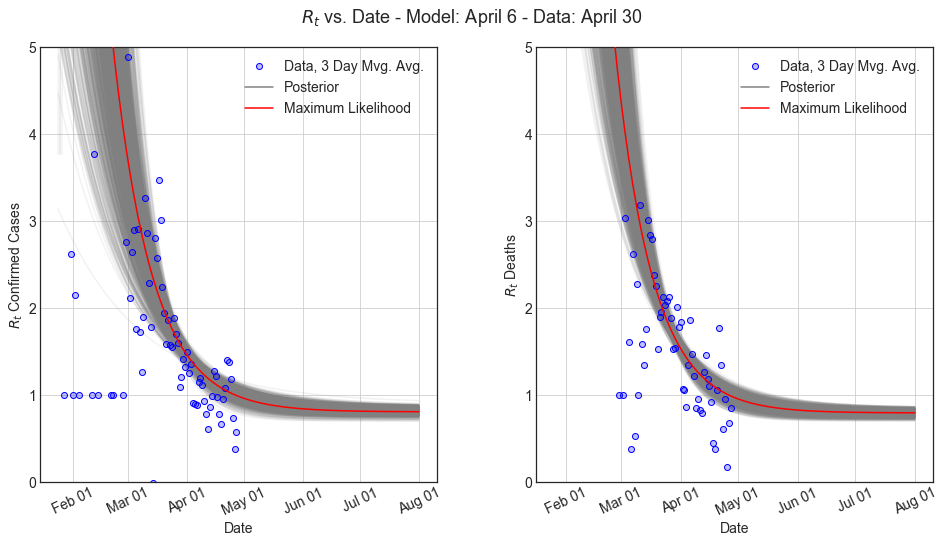

In [16]:
plot_rt(savefig=True, p=3, gamma=1./4.)

In [17]:
def rate_hist(savefig: bool = False):
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.distplot(trace['rate'], kde=False, bins=30, fit=lognorm, ax=ax)
    ax.plot([], [], c='k', label='Lognormal Fit')
    
    la = lognorm.args
    lq = lognorm.q
    
    mu = np.log(la[2])
    sigma = la[0]
    p10p90 = np.exp(sigma * NORM_80)
    mean = np.exp(mu + sigma ** 2 / 2)
    std = np.sqrt(mean ** 2 * (np.exp(sigma ** 2) - 1))
    
    ax.plot([mean, mean], [0, lognorm.pdf(mean)], c='k', ls='--', label='Mean')
    std_p1 = np.exp(mu + sigma ** 2 / 2 + sigma)
    std_m1 = np.exp(mu + sigma ** 2 / 2 - sigma)
    ax.plot([std_p1, std_p1], [0, lognorm.pdf(std_p1)], c='k', ls=':', Label='$\pm$ 1 Std. Dev.')
    ax.plot([std_m1, std_m1], [0, lognorm.pdf(std_m1)], c='k', ls=':')
    
    m = trace[np.argmax(trace['logp'])]['rate']
    ax.plot([m, m], [0, lognorm.pdf(m)], c='b', ls='--', label='Maximum Likelihood')
 
    if rate_mu is not None and rate_sigma is not None:
        sd = np.sqrt(np.log(rate_sigma**2 / rate_mu ** 2 + 1))
        mu = np.log(rate_mu) - sd ** 2 / 2
        ax.plot(lq, lognorm.pdf(lq, sd, 0, np.exp(mu)), c='C3', label='Prior')    


    ax.set(title=f'Fatality Rate Posterior - Model: {model_date}', xlabel='Fatality Rate', ylabel='Density')
    ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax.grid()
    ax.legend(loc='upper right')
    plt.tight_layout()

    if savefig:
        bname = 'Fatality Rate Posterior.png'
        fname = f'{model_date}_{bname}'
        plt.savefig(fname, dpi=75, bbox_inches='tight')
        cp(fname, bname)        
    else:
        plt.show()

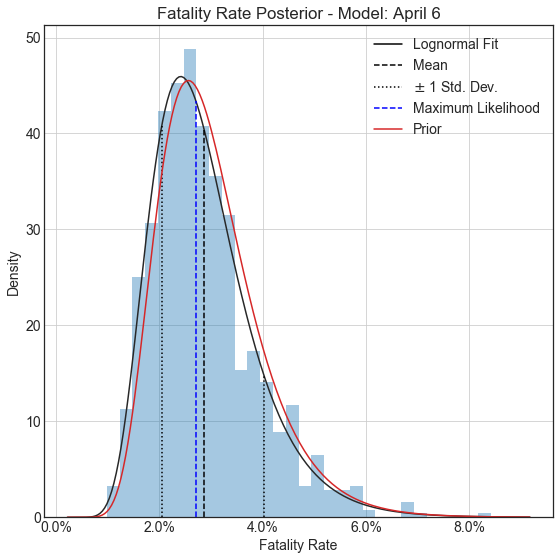

In [18]:
rate_hist(savefig=False)

In [19]:
def totals_hist(savefig: bool = False):
    ### cases        
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.distplot(trace['cases_b'], bins=30, kde=False, fit=lognorm, ax=ax)
    ax.plot([], [], c='k', label='Lognormal Fit')
    
    la = lognorm.args
    lq = lognorm.q
    
    mu = np.log(la[2])
    sigma = la[0]
    p10p90 = np.exp(sigma * NORM_80)
    mean = np.exp(mu + sigma ** 2 / 2)
    std = np.sqrt(mean ** 2 * (np.exp(sigma ** 2) - 1))
    
    ax.plot([mean, mean], [0, lognorm.pdf(mean)], c='k', ls='--', label='Mean')
    std_p1 = np.exp(mu + sigma ** 2 / 2 + sigma)
    std_m1 = np.exp(mu + sigma ** 2 / 2 - sigma)
    ax.plot([std_p1, std_p1], [0, lognorm.pdf(std_p1)], c='k', ls=':', Label='$\pm$ 1 Std. Dev.')
    ax.plot([std_m1, std_m1], [0, lognorm.pdf(std_m1)], c='k', ls=':')
    
    m = trace[np.argmax(trace['logp'])]['cases_b']
    ax.plot([m, m], [0, lognorm.pdf(m)], c='b', ls='--', label='Maximum Likelihood')    
    
    sd = np.log(cases_b_p10p90) / NORM_80
    mu = np.log(cases_b) - sd ** 2 / 2 
    ax.plot(lq, lognorm.pdf(lq, sd, 0, np.exp(mu)), c='C3', label='Prior')

    ax.set(title=f'Total Cases Posterior - Model: {model_date}', xlabel='Total Cases', ylabel='Density')
    ax.xaxis.set_major_formatter(mpl.ticker.EngFormatter())
    ax.grid()
    ax.legend(loc='upper right')
    plt.tight_layout()

    if savefig:
        bname = 'Total Cases Posterior.png'
        fname = f'{model_date}_{bname}'
        plt.savefig(fname, dpi=75, bbox_inches='tight')
        cp(fname, bname)          
    else:
        plt.show()
        
    ### deaths        
    fig, ax = plt.subplots(figsize=(8, 8))

    sns.distplot(trace['deaths_b'], bins=30, kde=False, fit=lognorm, ax=ax)
    ax.plot([], [], c='k', label='Lognormal Fit')
    
    la = lognorm.args
    lq = lognorm.q
    
    mu = np.log(la[2])
    sigma = la[0]
    p10p90 = np.exp(sigma * NORM_80)
    mean = np.exp(mu + sigma ** 2 / 2)
    std = np.sqrt(mean ** 2 * (np.exp(sigma ** 2) - 1))
    
    ax.plot([mean, mean], [0, lognorm.pdf(mean)], c='k', ls='--', label='Mean')
    std_p1 = np.exp(mu + sigma ** 2 / 2 + sigma)
    std_m1 = np.exp(mu + sigma ** 2 / 2 - sigma)
    ax.plot([std_p1, std_p1], [0, lognorm.pdf(std_p1)], c='k', ls=':', Label='$\pm$ 1 Std. Dev.')
    ax.plot([std_m1, std_m1], [0, lognorm.pdf(std_m1)], c='k', ls=':')   
    
    m = trace[np.argmax(trace['logp'])]['deaths_b']
    ax.plot([m, m], [0, lognorm.pdf(m)], c='b', ls='--', label='Maximum Likelihood')

    ax.set(title=f'Total Deaths Posterior - Model: {model_date}', xlabel='Total Deaths', ylabel='Density')
    ax.xaxis.set_major_formatter(mpl.ticker.EngFormatter())
    ax.grid()
    ax.legend(loc='upper right')
    plt.tight_layout()

    if savefig:
        bname = 'Total Deaths Posterior.png'
        fname = f'{model_date}_{bname}'
        plt.savefig(fname, dpi=75, bbox_inches='tight')
        cp(fname, bname)         
    else:
        plt.show()        

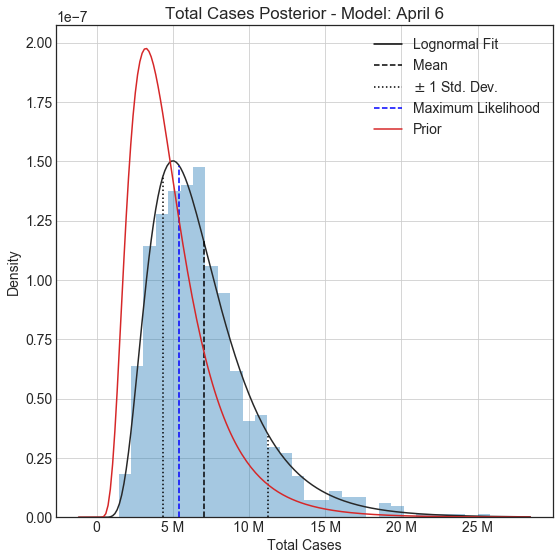

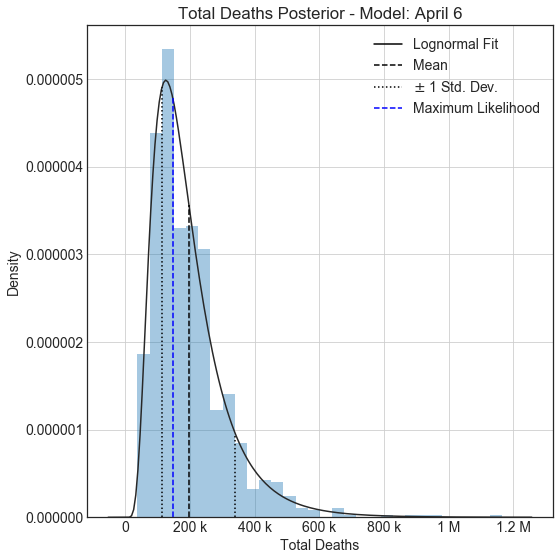

In [20]:
totals_hist(savefig=False)

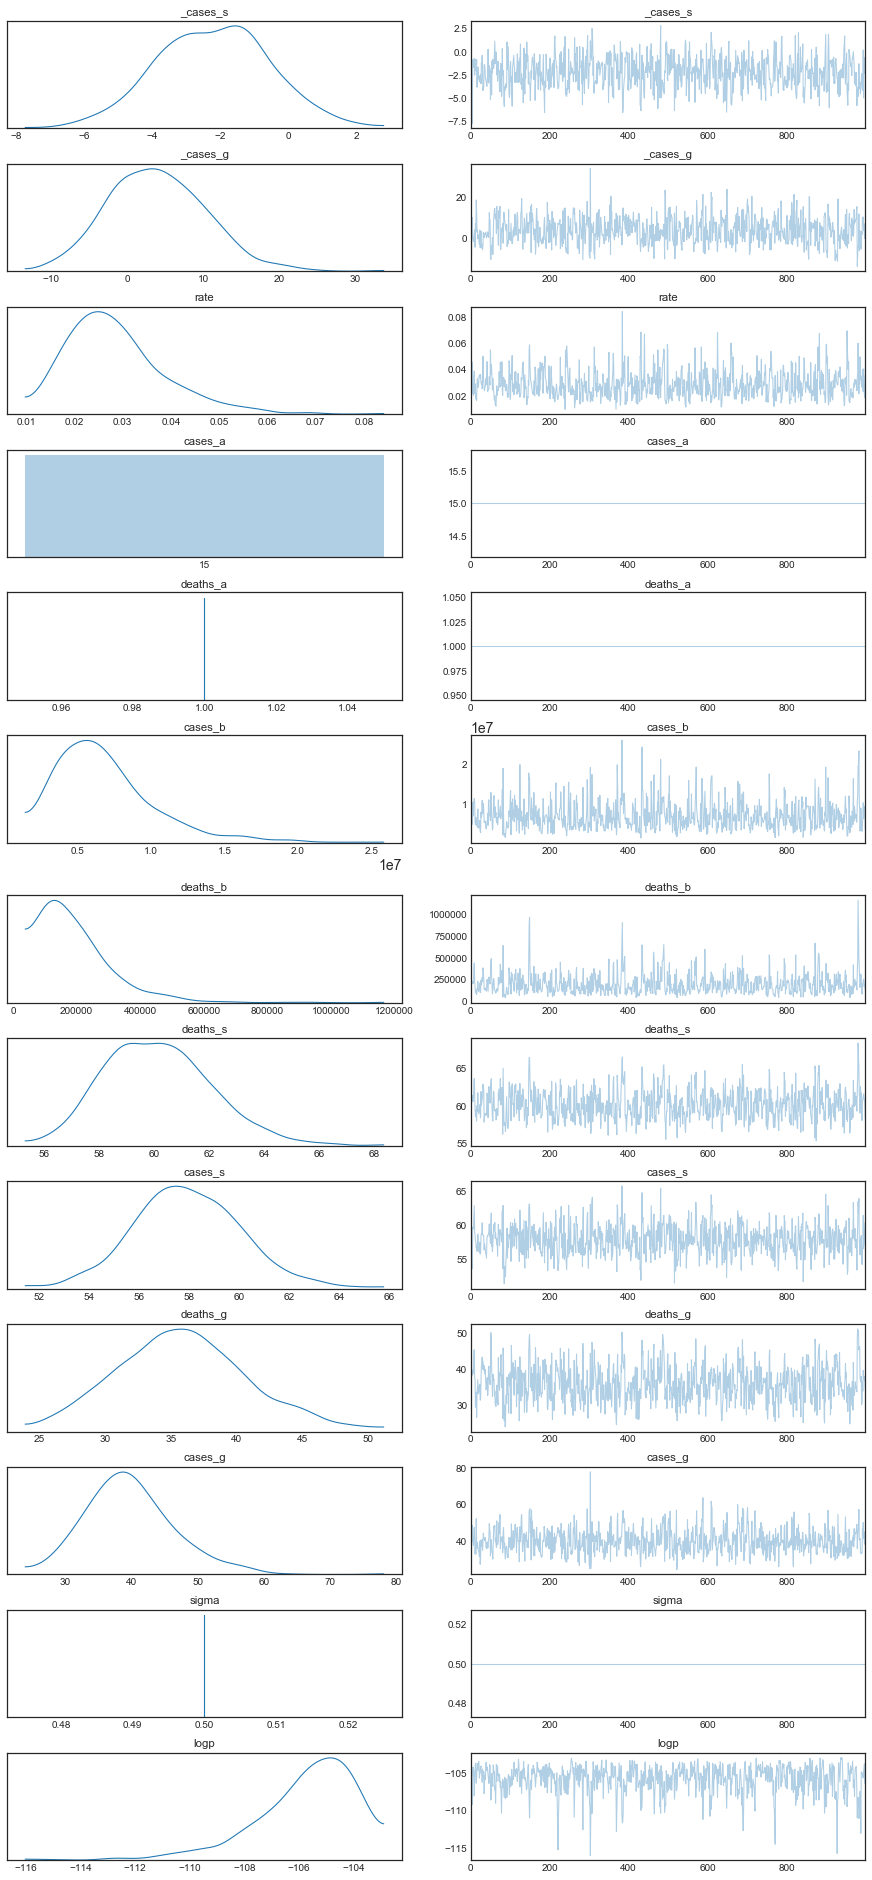

In [21]:
pm.plot_trace(trace)
plt.show()

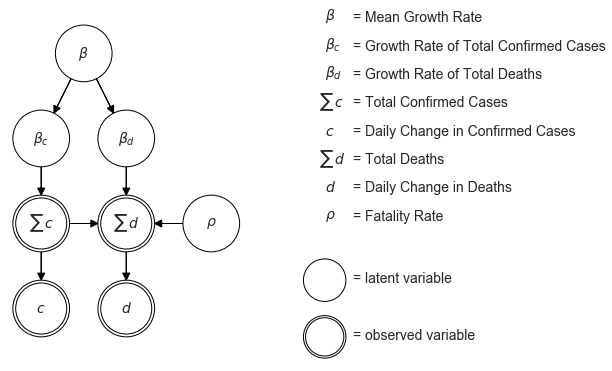

In [22]:
pgm = daft.PGM()
p_kw = {'scale': 2}
c_kw = {}#{'plot_params': {'ec': 'blue'}}
d_kw = {}#{'plot_params': {'ec': 'red'}}
e_kw = {'plot_params': {'head_width': .25}}

pgm.add_node('growth', r'$\beta$', x=.75, y=3, **p_kw)
pgm.add_node('c_growth', r'$\beta_c$', x=0, y=1.5, **p_kw)
pgm.add_node('d_growth', r'$\beta_d$', x=1.5, y=1.5, **p_kw)

pgm.add_node('cases', r'$\sum\,c$', x=0, y=0, **p_kw, **c_kw, alternate=True)
pgm.add_node('d_cases', r'$c$', x=0, y=-1.5, **p_kw, **c_kw, alternate=True)

pgm.add_node('deaths', r'$\sum\,d$', x=1.5, y=0, **p_kw, **d_kw, alternate=True)
pgm.add_node('d_deaths', r'$d$', x=1.5, y=-1.5, **p_kw, **d_kw, alternate=True)

pgm.add_node('rate', r'$\rho$', **p_kw, x=3, y=0)

pgm.add_edge('growth', 'c_growth', **c_kw, **e_kw)
pgm.add_edge('growth', 'd_growth', **c_kw, **e_kw)

pgm.add_edge('c_growth', 'cases', **c_kw, **e_kw)
pgm.add_edge('d_growth', 'deaths', **c_kw, **e_kw)

pgm.add_edge('cases', 'd_cases', **c_kw, **e_kw)
pgm.add_edge('deaths', 'd_deaths', **d_kw, **e_kw)
pgm.add_edge('cases', 'deaths', **c_kw, **e_kw)
pgm.add_edge('rate', 'deaths', **d_kw, **e_kw)

# Legend
x0 = 5.3
y0 = -1
pgm.add_node('latent', '', x0 - 0.3, y0, 1.5)
pgm.add_text(x0 + 0.2, y0 - 0.1, '= latent variable')
pgm.add_node('observed', '', x0 - 0.3, y0 - 1, 1.5, alternate=True)
pgm.add_text(x0 + 0.2, y0 - 1.1, '= observed variable')

x0 = 5.5
y0 = 2.
dx = -.5
dy = -.5

pgm.add_text(x0 + dx, y0 + -3 * dy, r'$\beta$')
pgm.add_text(x0, y0 + -3 * dy, '= Mean Growth Rate')
pgm.add_text(x0 + dx, y0 + -2 * dy, r'$\beta_c$')
pgm.add_text(x0, y0 + -2 * dy, '= Growth Rate of Total Confirmed Cases')
pgm.add_text(x0 + dx, y0 + -1 * dy, r'$\beta_d$')
pgm.add_text(x0, y0 + -1 * dy, '= Growth Rate of Total Deaths')

pgm.add_text(x0 + dx - .1, y0 + 0 * dy - .05, r'$\sum\,c$')
pgm.add_text(x0, y0 + 0 * dy, '= Total Confirmed Cases')
pgm.add_text(x0 + dx, y0 + 1 * dy, r'$c$')
pgm.add_text(x0, y0 + 1 * dy, '= Daily Change in Confirmed Cases')
pgm.add_text(x0 + dx - .1, y0 + 2 * dy - .05, r'$\sum\,d$')
pgm.add_text(x0, y0 + 2 * dy, '= Total Deaths')
pgm.add_text(x0 + dx, y0 + 3 * dy, r'$d$')
pgm.add_text(x0, y0 + 3 * dy, '= Daily Change in Deaths')
pgm.add_text(x0 + dx, y0 + 4 * dy, r'$\rho$')
pgm.add_text(x0, y0 + 4 * dy, '= Fatality Rate')

pgm.savefig('img/pgm.png', dpi=75, bbox_inches='tight')